### Libraries

In [1]:
import pdb
import pandas as pd
import numpy as np
import os
import random
from scipy import stats
from scipy.stats import gaussian_kde
from datetime import datetime, timedelta
from faker import Faker
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
np.random.seed(3101)
random_state = np.random.RandomState(3101)
fake = Faker()
pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x))

### Data Import

In [83]:
bank_df_train = pd.read_csv('./data/main/train.csv')
n_train = bank_df_train.shape[0]

### Data Cleaning

#### Remove Irrelevant Columns 

In [75]:
bank_df_train = bank_df_train.drop(["id", "CustomerId", "Surname", "CreditScore", "Geography", "HasCrCard"],axis = 1)

### Fixing given columns 

#### Balance

Removed those with 0 balance and used Normal dist from the remaining 
Then, added some noise/outliers 

In [76]:
zero_count = (bank_df_train['Balance'] == 0).sum()
total_count = len(bank_df_train)
zero_percentage = (zero_count / total_count) * 100

print(f"Percentage of 0 entries in 'Balance': {zero_percentage:.2f}%")

non_zero_data = bank_df_train.loc[bank_df_train['Balance'] != 0, 'Balance']
mean_non_zero = non_zero_data.mean()
std_non_zero = non_zero_data.std()

zero_indices = bank_df_train.index[bank_df_train['Balance'] == 0]
num_zeros = len(zero_indices)
random_samples = np.random.normal(loc=mean_non_zero, scale=std_non_zero, size=num_zeros)
bank_df_train.loc[zero_indices, 'Balance'] = random_samples

print(bank_df_train['Balance'].describe())

Percentage of 0 entries in 'Balance': 54.32%
count   165034.000000
mean    121485.561138
std      24997.963029
min         18.330000
25%     104877.953346
50%     121890.060000
75%     137946.390000
max     250898.090000
Name: Balance, dtype: float64


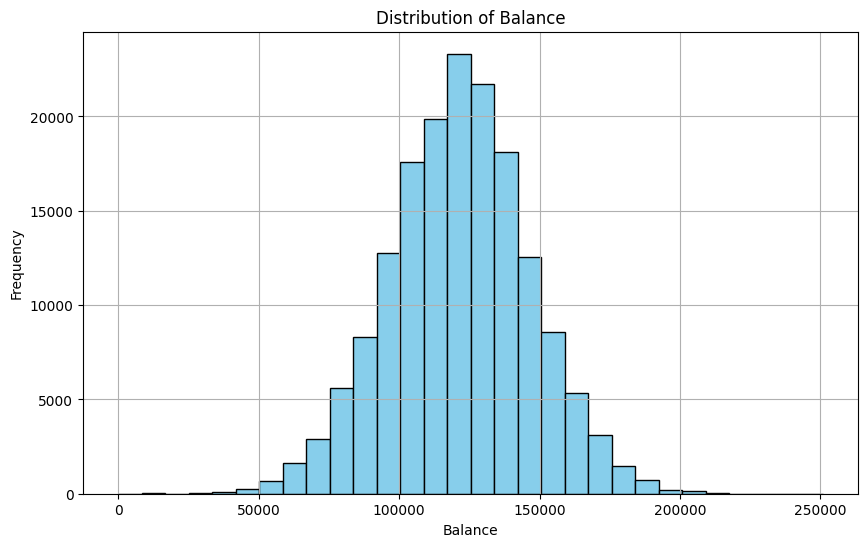

In [63]:
plt.figure(figsize=(10, 6))
plt.hist(bank_df_train['Balance'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('Distribution of Balance')
plt.grid(True)
plt.show()

#### Age 

Convert to int type 

In [77]:
bank_df_train['Age'] = bank_df_train['Age'].astype(int)

#### Tenure 

Scaled from Original Dataset to fit into 19 months 
Then, scaled to N(19,3.5) to fit GXS context 

In [84]:
aug_2022 = datetime(2022, 8, 31) #when GXS opened 
today = datetime.now()
months_since_aug_2022 = (today.year - aug_2022.year) * 12 + today.month - aug_2022.month - 2
def scale_int_to_months(int_val):
    return int_val * (months_since_aug_2022 / 10)
bank_df_train['Tenure'] = bank_df_train['Tenure'] * (months_since_aug_2022 / 10)
bank_df_train['Tenure'] = bank_df_train['Tenure'].astype(int)

# random_numbers = np.random.rand(n_train)
# threshold = 0.5
# print(random_numbers)
# bank_df_train.loc[random_numbers > threshold, 'Tenure'] += 1

print(bank_df_train['Tenure'].describe())

count   165034.000000
mean         8.624047
std          5.135385
min          0.000000
25%          5.000000
50%          9.000000
75%         12.000000
max         18.000000
Name: Tenure, dtype: float64


In [85]:
tenure_mean = bank_df_train['Tenure'].mean()
tenure_sd = bank_df_train['Tenure'].std()

bank_df_train['Tenure'] = ((bank_df_train['Tenure'] -tenure_mean)*(3.5/tenure_sd) + 18).astype(int)
bank_df_train['Tenure'] = np.minimum(bank_df_train['Tenure'], 19).astype(int)
bank_df_train['Tenure'].describe()

count   165034.000000
mean        16.607366
std          2.498349
min         12.000000
25%         15.000000
50%         18.000000
75%         19.000000
max         19.000000
Name: Tenure, dtype: float64

### Adding new columns 

#### Customer Id 

In [13]:
cust_id = np.arange(1,n_train+1,1)
bank_df_train['CustomerId'] = cust_id


#### KIV: Churn Date

#### KIV: Months Inactive

#### Transaction Freq & Amt 

In [ ]:
trans_df = pd.read_csv('./data/Daily Household Transactions.csv')

trans_df['Date'] = pd.to_datetime(trans_df['Date'], errors='coerce')

trans_df = trans_df.dropna(subset=['Date'])

trans_df['Date'] = trans_df['Date'].dt.strftime('%Y-%m-%d')

trans_df['Year'] = trans_df['Date'].str[:4].astype(int)
trans_df['Month'] = trans_df['Date'].str[5:7].astype(int)
trans_df['Day'] = trans_df['Date'].str[8:10].astype(int)
# print(trans_df['Date'].head(20))

exchange_rate_inr_to_sgd = 0.016
trans_df['Amount'] = trans_df['Amount'] * exchange_rate_inr_to_sgd
trans_df['Amount'] = trans_df['Amount'].round(2)


monthly_data = trans_df.groupby(['Year', 'Month']).agg({'Amount': 'sum', 'Date': 'count'}).reset_index()
monthly_data.rename(columns={'Amount': 'TotalAmount', 'Date': 'Frequency'}, inplace=True)
monthly_data['AvgTransactionPerMonth'] = monthly_data['TotalAmount'] / monthly_data['Frequency']

# print(monthly_data.head(20))


kde_freq = KernelDensity(bandwidth=1, kernel='gaussian')
kde_amount = KernelDensity(bandwidth=25, kernel='gaussian')

kde_freq.fit(monthly_data['Frequency'].values.reshape(-1, 1))
kde_amount.fit(monthly_data['AvgTransactionPerMonth'].values.reshape(-1, 1))

new_freq_samples = kde_freq.sample(len(bank_df_train)).reshape(-1)
new_amount_samples = kde_amount.sample(len(bank_df_train)).reshape(-1)

new_freq_samples_2 = kde_freq.sample(len(bank_df_test)).reshape(-1)
new_amount_samples_2 = kde_amount.sample(len(bank_df_test)).reshape(-1)

bank_df_train['TransactionFreq'] = new_freq_samples
bank_df_train['TransactionFreq'] = bank_df_train['TransactionFreq'].astype(int)
bank_df_train['TransactionAmt'] = new_amount_samples
percentile_75 = bank_df_train['TransactionAmt'].quantile(0.75)
# bank_df_train['TransactionAmt'] = bank_df_train['TransactionAmt'].apply(lambda x: max(x, percentile_75))

min_value = bank_df_train['TransactionAmt'].min()
max_value = bank_df_train['TransactionAmt'].max()
bank_df_train['TransactionAmt'] = ((bank_df_train['TransactionAmt'] - min_value) / (max_value - min_value)) * (percentile_75 - min_value) + percentile_75
print(bank_df_train[['TransactionFreq', 'TransactionAmt']].head(10))


bank_df_train['TransactionAmt'] = bank_df_train['TransactionAmt'] * bank_df_train['TransactionFreq']


bank_df_test['TransactionFreq'] = new_freq_samples_2
bank_df_test['TransactionFreq'] = bank_df_test['TransactionFreq'].astype(int)
bank_df_test['TransactionAmt'] = new_amount_samples_2

bank_df_train.loc[(bank_df_train['Exited'] == 1) | (bank_df_train['MonthsInactive'] > 0), ['TransactionFreq', 'TransactionAmt']] = 0

non_zero_mask = (bank_df_train['TransactionFreq'] != 0) & (bank_df_train['TransactionAmt'] != 0)
noise_freq = np.random.normal(0, 0.00, len(bank_df_train))
noise_amt = np.random.normal(1000, 500, len(bank_df_train))

bank_df_train.loc[non_zero_mask, 'TransactionFreq'] += noise_freq[non_zero_mask]
bank_df_train.loc[non_zero_mask, 'TransactionAmt'] += noise_amt[non_zero_mask]

bank_df_train['TransactionAmt'] = bank_df_train['TransactionAmt'].abs().round(2)

print(bank_df_train[['TransactionFreq', 'TransactionAmt']].head(10))
print(bank_df_train.describe)



non_zero_rows = bank_df_train[bank_df_train['TransactionAmt'] != 0] 
plt.figure(figsize=(10, 6))
plt.scatter(non_zero_rows['TransactionFreq'], non_zero_rows['TransactionAmt'], color='skyblue')
plt.title('Transaction Frequency vs. Transaction Amount (Non-Zero Transactions)')
plt.xlabel('Transaction Frequency')
plt.ylabel('Transaction Amount')
plt.grid(axis='both', linestyle='--', alpha=0.5)  
plt.tight_layout()
plt.show()

#### Service Support Freq (per mth)

Includes missed calls 

In [69]:
support_freq = pd.read_csv("./data/support_frequency.csv")
kde = gaussian_kde(support_freq['no_of_cases'])
bank_df_train['ServiceSupportFrequency'] = abs(kde.resample(n_train).flatten()/12).astype(int)

print(bank_df_train['ServiceSupportFrequency'].describe())


count   165034.000000
mean        13.348552
std         12.490492
min          0.000000
25%          4.000000
50%          9.000000
75%         20.000000
max         73.000000
Name: ServiceSupportFrequency, dtype: float64


#### Net Promoter Score (NPS)
Measure of customer satisfaction and loyalty.
Scaled from 1 to 10 


In [70]:
nps = pd.read_csv('./data/NPS.csv')

nps_data = nps.groupby('Customer Name').agg({'NPS':'mean'}).reset_index()
kde = gaussian_kde(nps_data['NPS'])
bank_df_train['NPS'] = abs(kde.resample(n_train).flatten()).astype(int)
bank_df_train['NPS'] = np.ceil(bank_df_train['NPS']/12*10)

print(bank_df_train['NPS'].describe())

count   165034.000000
mean         5.737745
std          2.986255
min          0.000000
25%          4.000000
50%          7.000000
75%          8.000000
max         10.000000
Name: NPS, dtype: float64


#### Education
Education level might influence financial behavior and churn.


In [71]:
education_marital = pd.read_csv("./data/education_marital.csv")
education = education_marital['Education_Level'].unique()
edu, counts = np.unique(education, return_counts=True)
value_to_index = {value: i for i, value in enumerate(edu)}
numerical_data = [value_to_index[value] for value in education]
kde = gaussian_kde(numerical_data)
x_values = np.unique(numerical_data)
pdf_values = kde(x_values)
pmf = pdf_values / np.sum(pdf_values)
resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)
resampled_values = [edu[index] for index in resampled_indices]

bank_df_train['Education'] = resampled_values
bank_df_train['Education'].replace({'Unknown': 'PSLE'}, inplace=True)
bank_df_train['Education'].replace({'Uneducated': np.random.choice(['A', 'Diploma'])}, inplace=True)
bank_df_train['Education'].replace({'High School': 'Bachelors'}, inplace=True)
bank_df_train['Education'].replace({'College': 'O/N'}, inplace=True)
bank_df_train['Education'].replace({'Graduate': 'Masters'}, inplace=True)
bank_df_train['Education'].replace({'Post-Graduate': 'PHD'}, inplace=True)
bank_df_train['Education'].replace({'Doctorate': 'Post-Doc'}, inplace=True)

print(bank_df_train['Education'].unique())

['Bachelors' 'Masters' 'Diploma' 'O/N' 'PHD' 'Post-Doc' 'PSLE']


In [72]:
bank_df_train['Education'].value_counts()

Education
Bachelors    27923
Masters      26974
PHD          26673
Diploma      23896
Post-Doc     23838
O/N          17868
PSLE         17862
Name: count, dtype: int64

#### Employment Status
Indicates financial stability, affecting churn likelihood

In [73]:
employment = pd.read_csv("./data/employment.csv")

employment_data = employment['job'].unique()

employment_status, counts = np.unique(employment_data, return_counts=True)
value_to_index = {value: i for i, value in enumerate(employment_status)}
numerical_data = [value_to_index[value] for value in employment_data]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)
pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)

resampled_values = [employment_status[index] for index in resampled_indices]

bank_df_train['EmploymentStatus'] = resampled_values

bank_df_train['EmploymentStatus'].replace({'admin.': 'Fulltime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'blue-collar': 'Fulltime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'entrepreneur': 'Fulltime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'housemaid': 'Parttime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'management': 'Fulltime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'retired': 'Retired'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'student': 'Student'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'services': 'Fulltime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'self-employed': 'Self-employed'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'technician': 'Parttime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'unemployed': 'Unemployed'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'unknown': 'Parttime'}, inplace=True)

print(bank_df_train['EmploymentStatus'].unique())

['Parttime' 'Fulltime' 'Self-employed' 'Student' 'Retired' 'Unemployed']


#### Marital Status
Can impact financial decision-making and churn behavior. 

In [74]:
education_marital = pd.read_csv("./data/education_marital.csv")

marital_status = education_marital['Marital_Status'].unique()

marital, counts = np.unique(marital_status, return_counts=True)
value_to_index = {value: i for i, value in enumerate(marital)}
numerical_data = [value_to_index[value] for value in marital_status]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)

pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)

resampled_values = [marital[index] for index in resampled_indices]

bank_df_train['MaritalStatus'] = resampled_values

bank_df_train['MaritalStatus'].replace({'Unknown': 'Widowed'}, inplace=True)

print(bank_df_train['MaritalStatus'].unique())

['Married' 'Single' 'Widowed' 'Divorced']


#### Housing Status
Reflects stability and long-term commitment, influencing churn. 

In [75]:
housing = pd.read_csv("./data/housing.csv")

housing_status = housing['House_Ownership'].unique()

house, counts = np.unique(housing_status, return_counts=True)
value_to_index = {value: i for i, value in enumerate(house)}
numerical_data = [value_to_index[value] for value in housing_status]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)

pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)

resampled_values = [house[index] for index in resampled_indices]

bank_df_train['HousingStatus'] = resampled_values

print(bank_df_train['HousingStatus'].unique())

['owned' 'norent_noown' 'rented']


#### Number of Dependents
Impacts financial priorities and risk tolerance, affecting churn.

In [76]:
dependants_df = pd.read_csv('./data/education+dependents+maritalstatus/BankChurners.csv')

kde = gaussian_kde(dependants_df['Dependent_count'])

bank_df_train['Dependants'] = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
bank_df_train['Dependants'] = np.round(bank_df_train['Dependants']).astype(int)

print(bank_df_train['Dependants'].describe())
print(bank_df_train['Dependants'].unique())

count   165034.000000
mean         2.343687
std          1.305842
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: Dependants, dtype: float64
[3 4 2 0 1 5 6]


#### Marketing Offers Accepted
Indicates responsiveness to incentives, affecting churn. Range 0-1, (percentage of marketing offers they accept, e.g.5 offer, 4 accepted, the value of the column 0.8)

In [77]:
marketing_df = pd.read_csv('./data/marketing offers/marketing_campaign.csv', sep=';')

marketing_df["MarketingOffersAcceptance"] = (marketing_df['AcceptedCmp1'] + marketing_df['AcceptedCmp2'] + marketing_df['AcceptedCmp3'] + marketing_df['AcceptedCmp4'] + marketing_df['AcceptedCmp5']) / 5

kde = gaussian_kde(marketing_df['MarketingOffersAcceptance'])

bank_df_train['MarketingOffersAcceptance'] = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)

print(bank_df_train['MarketingOffersAcceptance'].describe())

count   165034.000000
mean         0.068896
std          0.133310
min          0.000000
25%          0.000000
50%          0.009626
75%          0.046468
max          0.878459
Name: MarketingOffersAcceptance, dtype: float64


#### Preferred Payment Methods 
Reflects preferred banking channels and engagement level. 
faker

In [78]:
transaction_channel_df = pd.read_csv('./data/main_payment_method/WA_Fn-UseC_-Telco-Customer-Churn.csv')
methods = transaction_channel_df['PaymentMethod'].unique().tolist()
faked_data = [random.choice(methods) for _ in range(len(bank_df_train))]

bank_df_train['PaymentMethod'] = faked_data

bank_df_train['PaymentMethod'].replace({'Bank transfer (automatic)': 'Intrabank transfer (GXS Savings Account only)'}, inplace=True)
bank_df_train['PaymentMethod'].replace({'Electronic check': 'PayNow'}, inplace=True)
bank_df_train['PaymentMethod'].replace({'Credit card (automatic)': 'Debit card'}, inplace=True)
bank_df_train['PaymentMethod'].replace({'Mailed check': 'FAST'}, inplace=True)

print(bank_df_train['PaymentMethod'].unique())

['PayNow' 'Intrabank transfer (GXS Savings Account only)' 'Debit card'
 'FAST']


#### Brand Satisfaction
Provides direct feedback on satisfaction levels, predicting churn. 

In [79]:
cust_satisfaction_df = pd.read_csv('./data/satisfaction score/Customer-Churn-Records.csv')

kde = gaussian_kde(cust_satisfaction_df['Satisfaction Score'])

fake_data = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
fake_data = np.minimum(fake_data.flatten(), 5)
fake_data = np.round(fake_data).astype(int)

bank_df_train['BrandSatisfaction'] = fake_data

print(bank_df_train['BrandSatisfaction'].describe())

count   165034.000000
mean         3.011573
std          1.410494
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: BrandSatisfaction, dtype: float64


#### Feature Satisfaction
Scale on 1 to 5


In [80]:
feature_df = pd.read_csv('./data/feature_and_support_satisfaction/Customer-survey-data.csv')
feature_df = feature_df.dropna()
kde = gaussian_kde(feature_df['How satisfied were you with your overall delivery experience at Ali?                    1-5 where 1 = extremely dissatisfied and 5 = extremely satisfied'])
bank_df_train['FeatureSatisfaction'] = kde.resample(len(bank_df_train)).flatten().astype(int)
bank_df_train['FeatureSatisfaction'] = bank_df_train['FeatureSatisfaction']
bank_df_train['FeatureSatisfaction'] = bank_df_train['FeatureSatisfaction'].astype(int)
print(bank_df_train['FeatureSatisfaction'].unique())
print(bank_df_train['FeatureSatisfaction'].describe())

[0 1 4 5 2 3]
count   165034.000000
mean         2.816517
std          1.508244
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: FeatureSatisfaction, dtype: float64


#### Support Satisfaction
Scale on 1 to 5


In [81]:
feature_df = pd.read_csv('./data/feature_and_support_satisfaction/Customer-survey-data.csv')
feature_df = feature_df.dropna()
kde = gaussian_kde(feature_df['How satisfied were you with the speed of delivery at Alis?                                1-5 where 1 = extremely dissatisfied and 5 = extremely satisfied'])
bank_df_train['SupportSatisfaction'] = kde.resample(len(bank_df_train)).flatten().astype(int)

print(bank_df_train['SupportSatisfaction'].unique())
print(bank_df_train['SupportSatisfaction'].describe())

[3 4 1 5 2 0]
count   165034.000000
mean         2.825278
std          1.491990
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: SupportSatisfaction, dtype: float64
